# UE mobility prediction

The UE connects via a DN to the closest application server. Next, it moves to the next edge site. To keep latency low after a gNB handover, the UE’s context should be relocated not only on the gNB, but also on the UPF and the application server.

If the network knows in advance that the UE will move to the target edge site, then some parts of the relocation procedure can be done before the actual gNB handover. In this way, the overall procedure is shortened, and the handover can be performed more smoothly.


<div>
<img src="../image.png" width="400">
</div>

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

## Data analysis

The dataset in `trajectories.json.gz` is made of events carrying the following features:
* `currentEnb`: gNB the user has moved to 
* `eventId`: type of event
* `imsi`: IMSI (user identifier) the event belongs to. 
* `timestamp`: minutes starting from 0 at day 1 in the dataset. The dataset contains data from about four days and a half 
* `timeSlot`: a 15-minute slot generated from timestamp. There should be 96 timeslots in a day. `timeSlot` is restarted every day. 

## Exploratory Data Analysis

In [3]:
df = pd.read_json('trajectories.json.gz', compression='gzip')
df.head()

,currentEnb,eventId,imsi,timeSlot,timestamp
0,22,12,2778514794,0,0
1,16,12,2793518354,0,0
2,37,12,2793522274,0,0
3,15,12,2781330414,0,0
4,18,12,2793525404,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479154 entries, 0 to 479153
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   currentEnb  479154 non-null  int64
 1   eventId     479154 non-null  int64
 2   imsi        479154 non-null  int64
 3   timeSlot    479154 non-null  int64
 4   timestamp   479154 non-null  int64
dtypes: int64(5)
memory usage: 18.3 MB


In [5]:
df.nunique()

currentEnb      41
eventId          1
imsi          8687
timeSlot        15
timestamp     1036
dtype: int64

In [6]:
df[df['imsi'] == 2785554734]

,currentEnb,eventId,imsi,timeSlot,timestamp
5677,29,12,2785554734,0,0
10037,30,12,2785554734,0,2
30897,3,12,2785554734,1,20
39450,31,12,2785554734,1,29
40386,3,12,2785554734,2,30
...,...,...,...,...,...
479146,29,12,2785554734,54,6580
479149,30,12,2785554734,54,6581
479150,29,12,2785554734,54,6582
479151,30,12,2785554734,54,6583


Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:>

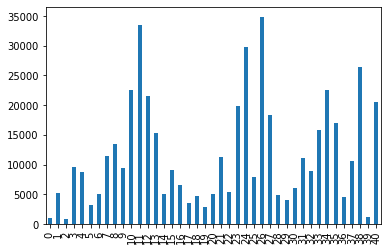

In [7]:
df['currentEnb'].value_counts().sort_index().plot(kind='bar')

<AxesSubplot:>

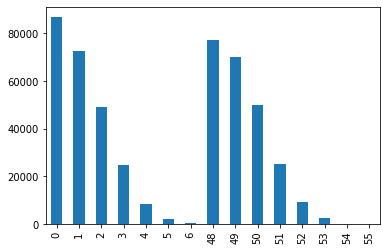

In [8]:
df['timeSlot'].value_counts().sort_index().plot(kind='bar')

In [9]:
df['timestamp'].max()

6587

<AxesSubplot:>

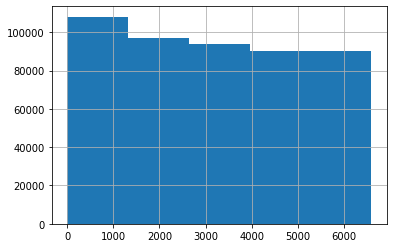

In [10]:
df['timestamp'].hist(bins=5)

### Additional data sources

For each gNodeB, `topology_neighbours.json` contains its closest neighbours.

In [11]:
gnb_neigh = pd.read_json('topology_neighbours.json', orient='index')
gnb_neigh.reset_index(inplace=True)
gnb_neigh.columns = ['gnodeB', 'neigh_1', 'neigh_2', 'neigh_3', 'neigh_4']
gnb_neigh.head()

,gnodeB,neigh_1,neigh_2,neigh_3,neigh_4
0,0,5,2,16,4
1,29,1,30,5,3
2,5,1,0,2,4
3,1,5,29,4,3
4,3,31,1,8,30


## Feature engineering

First, we select the first day as train set.

In [12]:
day_1 = df.loc[(df['timestamp']>=0) & (df['timestamp']<1440)]
day_2 = df.loc[(df['timestamp']>=1440) & (df['timestamp']<2880)]

For each EMB event, we create a number of new features:
* `stay_time`: time until the same user moves to another gNodeB (and thus a new event is received).
* `transit_time`: time it took the user to move from the the previous gNodeB. For a same user that goes from gNodeB-a to gNodeB-b, `stay_time` in gNodeB-A is the same as `transit_time` in gNodeB-b
* `transition_slot`: bucketed `transit_time` considering that any time greater than 60 minutes is assigned 100 minutes.
* `time_of_day`: bucketed `timeSlot` (five periods of time in the day).

In [13]:
grouped_df = day_1.set_index(['imsi', 'timestamp']).sort_index().reset_index()
grouped_df['next_timestamp'] = grouped_df.groupby(['imsi'])['timestamp'].shift(-1)
grouped_df['prev_timestamp'] = grouped_df.groupby(['imsi'])['timestamp'].shift(1)
grouped_df['stay_time'] = grouped_df['next_timestamp'] - grouped_df['timestamp']
grouped_df['transit_time'] = grouped_df['timestamp'] - grouped_df['prev_timestamp']

<AxesSubplot:>

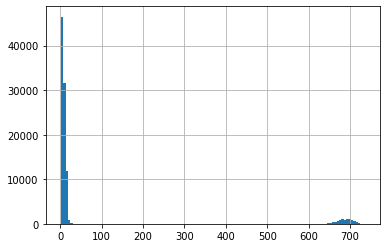

In [14]:
grouped_df['stay_time'].hist(bins=128)

See the peak around 700 minutes, that could correspond to people remaining at work for such period of time. It's interesting to note than bucketing to create `transition_slot` takes the maximum value of its bucket but in the larger bucket, where the value is set to 100. That is, all values greater than 60 (one hour) are set to 100.

In [15]:
grouped_df['transit_time'].max()

737.0

In [16]:
max_transit_time = grouped_df['transit_time'].max()
grouped_df['transition_slot'] = pd.cut(grouped_df['transit_time'], 
                                       [0, 1, 5, 15, 30, 60, max_transit_time],
                                       labels=[1, 5, 15, 30, 60, 100])
grouped_df['transition_slot'].value_counts().sort_index()

1      25608
5      17234
15     43919
30      4085
60         0
100     8634
Name: transition_slot, dtype: int64

<AxesSubplot:>

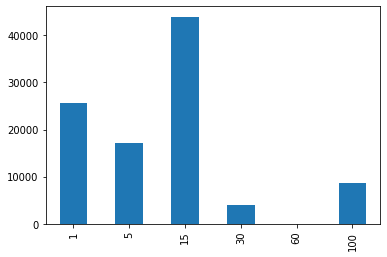

In [17]:
grouped_df['transition_slot'].value_counts().sort_index().plot(kind='bar')

Five equal bins are defined. However, as the upper limit is the maximum value in `timeSlot`, assignment has not much to do with the intended meaning of the bins.

In [18]:
grouped_df['time_of_day'] = pd.cut(grouped_df['timeSlot'],
                                   bins=5,
                                   labels=['early_morn', 'morning', 'noon', 'evening', 'night'])

In [19]:
grouped_df['time_of_day'].value_counts().reindex(index=['early_morn', 'morning', 'noon', 'evening', 'night'])

early_morn    58073
morning           0
noon              0
evening           0
night         50041
Name: time_of_day, dtype: int64

<AxesSubplot:>

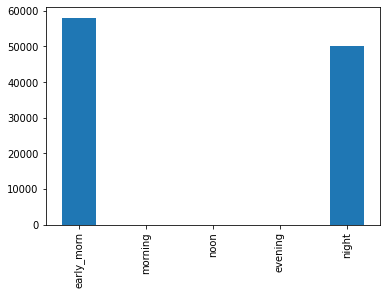

In [20]:
grouped_df['time_of_day'].value_counts().reindex(index=['early_morn', 'morning', 'noon', 'evening', 'night']).plot(kind='bar')

`ue_home_df` records how long a given user is at a given gNodeB (from `stay_time`)

In [21]:
ue_home_df = grouped_df.groupby(['imsi', 'currentEnb'])['stay_time'].sum().reset_index()
ue_home_df.head()

,imsi,currentEnb,stay_time
0,2778514794,6,8.0
1,2778514794,9,2.0
2,2778514794,13,2.0
3,2778514794,18,8.0
4,2778514794,21,11.0


`home_df` records the gNodeB where each user stays for longer

In [22]:
home_gnb = ue_home_df.loc[ue_home_df.groupby(['imsi'])['stay_time'].idxmax()][['imsi', 'currentEnb']]
home_gnb.columns = ['imsi', 'home_gnb']
home_gnb.head()

,imsi,home_gnb
8,2778514794,40
12,2778531564,27
21,2778535004,38
22,2778540704,7
30,2778543964,26


`ue_df` records the number of gNodeB's a given user is in for each time of the day

In [23]:
ue_df = grouped_df.groupby(['imsi', 'time_of_day'])['currentEnb'].count().reset_index()
ue_df.head()

,imsi,time_of_day,currentEnb
0,2778514794,early_morn,8
1,2778514794,morning,0
2,2778514794,noon,0
3,2778514794,evening,0
4,2778514794,night,4


`ue_ctxt_df` contains the same information than `ue_df` but pivotted to show a user per row

In [24]:
ue_ctxt_df = pd.pivot_table(ue_df, index='imsi', columns='time_of_day', values='currentEnb', fill_value=0)
ue_ctxt_df.head()

time_of_day,early_morn,morning,noon,evening,night
imsi,,,,,
2778514794,8,0,0,0,4
2778531564,4,0,0,0,6
2778535004,5,0,0,0,7
2778540704,5,0,0,0,5
2778543964,3,0,0,0,9


`seq_df` is an auxiliary dataframe that, for each user, provides its trajectory, the time where each transition happened, the bucketed time it took for each user to move from the previous gNodeB and the signal strength in each gNodeB

In [25]:
seq_df = grouped_df.groupby(['imsi'])['currentEnb', 'timeSlot','transition_slot'] \
                   .agg(lambda x: list(x)).reset_index()

seq_df.head()

,imsi,currentEnb,timeSlot,transition_slot
0,2778514794,"[22, 18, 9, 23, 13, 23, 13, 40, 6, 21, 22, 39]","[0, 0, 1, 1, 2, 2, 2, 2, 48, 49, 49, 50]","[nan, 15, 15, 5, 15, 1, 1, 1, 100, 15, 15, 15]"
1,2778531564,"[10, 11, 26, 27, 38, 26, 38, 26, 34, 10]","[0, 0, 1, 1, 48, 49, 49, 49, 49, 50]","[nan, 5, 15, 15, 100, 15, 1, 1, 5, 15]"
2,2778535004,"[17, 15, 32, 35, 38, 26, 38, 35, 32, 15, 14, 17]","[0, 0, 0, 1, 1, 48, 48, 48, 49, 49, 49, 50]","[nan, 5, 15, 15, 15, 100, 1, 5, 15, 5, 15, 5]"
3,2778540704,"[35, 38, 26, 27, 7, 27, 24, 26, 38, 35]","[0, 0, 0, 1, 2, 48, 48, 49, 49, 50]","[nan, 5, 15, 5, 30, 100, 5, 15, 15, 5]"
4,2778543964,"[7, 24, 26, 27, 24, 27, 24, 27, 24, 27, 24, 7]","[0, 0, 1, 48, 48, 48, 48, 48, 48, 48, 49, 49]","[nan, 5, 15, 100, 1, 1, 1, 1, 1, 1, 1, 5]"


In [26]:
def window_sequence(seq, window_size=5):
    """This function turns a sequence intro 
    a matrix where each row is a sequence of
    the previous 'windows_size' elements"""
    
    windows = []
    seq_len = len(seq)
    for i in range(len(seq) - window_size + 1):
        window = []
        for j in range(i, i + window_size):
            window.append(seq[j])
        windows.append(window)
    return windows

Each feature in `seq_df` creates a new feature where the sequences from the original feature is recorded (five elements in each sequence):
* `gnode_seq` records the sequences of each gNodeB in `currentEnb`.
* `time_seq` records the sequences of each timeslots in `timeSlot`.
* `trans_seq` records the sequences of each transition slots in `transition_slot`.

Additionally, we create a new feature with the number of transitions:
* `seq_len`

In [27]:
seq_df['gnode_seq'] = seq_df['currentEnb'].apply(window_sequence).values
seq_df['time_seq'] = seq_df['timeSlot'].apply(window_sequence).values
seq_df['trans_seq'] = seq_df['transition_slot'].apply(window_sequence).values
seq_df['seq_len'] = seq_df['gnode_seq'].apply(lambda x: len(x))
seq_df

,imsi,currentEnb,timeSlot,transition_slot,gnode_seq,time_seq,trans_seq,seq_len
0,2778514794,"[22, 18, 9, 23, 13, 23, 13, 40, 6, 21, 22, 39]","[0, 0, 1, 1, 2, 2, 2, 2, 48, 49, 49, 50]","[nan, 15, 15, 5, 15, 1, 1, 1, 100, 15, 15, 15]","[[22, 18, 9, 23, 13], [18, 9, 23, 13, 23], [9,...","[[0, 0, 1, 1, 2], [0, 1, 1, 2, 2], [1, 1, 2, 2...","[[nan, 15, 15, 5, 15], [15, 15, 5, 15, 1], [15...",8
1,2778531564,"[10, 11, 26, 27, 38, 26, 38, 26, 34, 10]","[0, 0, 1, 1, 48, 49, 49, 49, 49, 50]","[nan, 5, 15, 15, 100, 15, 1, 1, 5, 15]","[[10, 11, 26, 27, 38], [11, 26, 27, 38, 26], [...","[[0, 0, 1, 1, 48], [0, 1, 1, 48, 49], [1, 1, 4...","[[nan, 5, 15, 15, 100], [5, 15, 15, 100, 15], ...",6
2,2778535004,"[17, 15, 32, 35, 38, 26, 38, 35, 32, 15, 14, 17]","[0, 0, 0, 1, 1, 48, 48, 48, 49, 49, 49, 50]","[nan, 5, 15, 15, 15, 100, 1, 5, 15, 5, 15, 5]","[[17, 15, 32, 35, 38], [15, 32, 35, 38, 26], [...","[[0, 0, 0, 1, 1], [0, 0, 1, 1, 48], [0, 1, 1, ...","[[nan, 5, 15, 15, 15], [5, 15, 15, 15, 100], [...",8
3,2778540704,"[35, 38, 26, 27, 7, 27, 24, 26, 38, 35]","[0, 0, 0, 1, 2, 48, 48, 49, 49, 50]","[nan, 5, 15, 5, 30, 100, 5, 15, 15, 5]","[[35, 38, 26, 27, 7], [38, 26, 27, 7, 27], [26...","[[0, 0, 0, 1, 2], [0, 0, 1, 2, 48], [0, 1, 2, ...","[[nan, 5, 15, 5, 30], [5, 15, 5, 30, 100], [15...",6
4,2778543964,"[7, 24, 26, 27, 24, 27, 24, 27, 24, 27, 24, 7]","[0, 0, 1, 48, 48, 48, 48, 48, 48, 48, 49, 49]","[nan, 5, 15, 100, 1, 1, 1, 1, 1, 1, 1, 5]","[[7, 24, 26, 27, 24], [24, 26, 27, 24, 27], [2...","[[0, 0, 1, 48, 48], [0, 1, 48, 48, 48], [1, 48...","[[nan, 5, 15, 100, 1], [5, 15, 100, 1, 1], [15...",8
...,...,...,...,...,...,...,...,...
8629,2797485664,"[33, 34, 35, 38, 37, 38, 35, 34, 33]","[0, 0, 0, 1, 1, 1, 48, 48, 49]","[nan, 15, 5, 15, 1, 1, 100, 15, 15]","[[33, 34, 35, 38, 37], [34, 35, 38, 37, 38], [...","[[0, 0, 0, 1, 1], [0, 0, 1, 1, 1], [0, 1, 1, 1...","[[nan, 15, 5, 15, 1], [15, 5, 15, 1, 1], [5, 1...",5
8630,2797487414,"[38, 26, 11, 24, 13, 24, 13, 24, 40, 24, 27, 2...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 48, 48, 49, 49]","[nan, 5, 15, 15, 1, 1, 1, 1, 5, 100, 15, 5, 5]","[[38, 26, 11, 24, 13], [26, 11, 24, 13, 24], [...","[[0, 0, 0, 1, 1], [0, 0, 1, 1, 1], [0, 1, 1, 1...","[[nan, 5, 15, 15, 1], [5, 15, 15, 1, 1], [15, ...",9
8631,2797489164,"[10, 11, 13, 24, 11, 10]","[0, 0, 0, 0, 48, 49]","[nan, 1, 15, 5, 100, 15]","[[10, 11, 13, 24, 11], [11, 13, 24, 11, 10]]","[[0, 0, 0, 0, 48], [0, 0, 0, 48, 49]]","[[nan, 1, 15, 5, 100], [1, 15, 5, 100, 15]]",2
8632,2797490924,"[15, 33, 34, 26, 38, 27, 38, 27, 37, 35, 32, 15]","[0, 0, 0, 1, 2, 2, 2, 2, 48, 49, 50, 50]","[nan, 5, 15, 15, 15, 5, 1, 1, 100, 30, 15, 5]","[[15, 33, 34, 26, 38], [33, 34, 26, 38, 27], [...","[[0, 0, 0, 1, 2], [0, 0, 1, 2, 2], [0, 1, 2, 2...","[[nan, 5, 15, 15, 15], [5, 15, 15, 15, 5], [15...",8


Next, we transform each sequence feature into a new dataframe

In [28]:
enode_seq_list = [sequence for sequences in seq_df['gnode_seq'] for sequence in sequences]
time_seq_list = [sequence for sequences in seq_df['time_seq'] for sequence in sequences]
trans_seq_list = [sequence for sequences in seq_df['trans_seq'] for sequence in sequences]

enode_df = pd.DataFrame(enode_seq_list, columns=['gnode_1', 'gnode_2', 'gnode_3', 'gnode_4', 'target_gnb'])
time_df = pd.DataFrame(time_seq_list, columns=['time_1', 'time_2', 'time_3', 'time_4', 'target_time'])
trans_df = pd.DataFrame(trans_seq_list, columns=['trans_1', 'trans_2', 'trans_3', 'trans_4', 'target_trans_slot'])

In [29]:
imsi_list = list()
for a, b in zip(seq_df['imsi'], seq_df['seq_len']):
    imsi_list.extend([a] * b)

Finally, we create the dataset that will be used for prediction. What we want to predict is what follows: given a detected transition to a given gNodeB, which will be the following gNodeB and when will it happen?

Thus, the targets are:
* `target_gnb`: Next gNodeB
* `target_trans_slot`: Time it will take to move to the next gNodeB.

The following features will be considered:
* `enode_1`: The fourth previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `enode_2`: The third previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `enode_3`: The second previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `enode_4`: The first previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `time_1`: The time where the user moved to the fourth previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `time_2`: The time where the user moved to the third previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `time_3`: The time where the user moved to the second previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `time_4`: The time where the user moved to the first previous gNodeB in a given sequence. Depends on the current user's trajectory.
* `home_gnb`: The gNodeB where the user doing for a given trajectory stays more times within a day. It's is a historical data.
* `early_morn`: The number of gNodeB's where the user for a given trajectory stays in the early morning. It's is a historical data.
* `morning`: The number of gNodeB's where the user for a given trajectory stays in the morning. It's is a historical data.
* `noon`: The number of gNodeB's where the user for a given trajectory stays at noon. It's is a historical data.
* `evening`: The number of gNodeB's where the user for a given trajectory stays in the evening. It's is a historical data.
* `night`: The number of gNodeB's where the user for a given trajectory stays at night. It's is a historical data.
* `neigh_1`: One of the four closest gNodeB's to `enode_4`. It's is a static data.
* `neigh_2`: One of the four closest gNodeB's to `enode_4`. It's is a static data.
* `neigh_3`: One of the four closest gNodeB's to `enode_4`. It's is a static data.
* `neigh_4`: One of the four closest gNodeB's to `enode_4`. It's is a static data.

In [30]:
#### CHANGES
X_train = pd.concat([enode_df, time_df], axis=1)
X_train['target_trans_slot'] = trans_df['target_trans_slot']
X_train['imsi'] = imsi_list
X_train

,gnode_1,gnode_2,gnode_3,gnode_4,target_gnb,time_1,time_2,time_3,time_4,target_time,target_trans_slot,imsi
0,22,18,9,23,13,0,0,1,1,2,15,2778514794
1,18,9,23,13,23,0,1,1,2,2,1,2778514794
2,9,23,13,23,13,1,1,2,2,2,1,2778514794
3,23,13,23,13,40,1,2,2,2,2,1,2778514794
4,13,23,13,40,6,2,2,2,2,48,100,2778514794
...,...,...,...,...,...,...,...,...,...,...,...,...
73573,34,26,24,27,24,0,0,1,1,1,1,2797492664
73574,26,24,27,24,26,0,1,1,1,48,100,2797492664
73575,24,27,24,26,11,1,1,1,48,48,5,2797492664
73576,27,24,26,11,34,1,1,48,48,49,15,2797492664


In [31]:
X_train = X_train.merge(home_gnb, on='imsi').merge(ue_ctxt_df, on='imsi')

In [32]:
X_train = X_train.merge(gnb_neigh, left_on='gnode_4', right_on='gnodeB', how='left')

In [33]:
del X_train['gnodeB']

In [34]:
X_train.dropna(inplace=True)
X_train

,gnode_1,gnode_2,gnode_3,gnode_4,target_gnb,time_1,time_2,time_3,time_4,target_time,...,home_gnb,early_morn,morning,noon,evening,night,neigh_1,neigh_2,neigh_3,neigh_4
0,22,18,9,23,13,0,0,1,1,2,...,40,8,0,0,0,4,21,6,13,9
1,18,9,23,13,23,0,1,1,2,2,...,40,8,0,0,0,4,11,23,24,40
2,9,23,13,23,13,1,1,2,2,2,...,40,8,0,0,0,4,21,6,13,9
3,23,13,23,13,40,1,2,2,2,2,...,40,8,0,0,0,4,11,23,24,40
4,13,23,13,40,6,2,2,2,2,48,...,40,8,0,0,0,4,25,6,24,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73573,34,26,24,27,24,0,0,1,1,1,...,24,6,0,0,0,4,24,7,26,38
73574,26,24,27,24,26,0,1,1,1,48,...,24,6,0,0,0,4,40,13,27,26
73575,24,27,24,26,11,1,1,1,48,48,...,24,6,0,0,0,4,11,38,34,24
73576,27,24,26,11,34,1,1,48,48,49,...,24,6,0,0,0,4,13,26,34,10


In [35]:
y_train = X_train[['target_gnb', 'target_trans_slot']]
y_train

,target_gnb,target_trans_slot
0,13,15
1,23,1
2,13,1
3,40,1
4,6,100
...,...,...
73573,24,1
73574,26,100
73575,11,5
73576,34,15


In [36]:
to_drop_cols = ['target_gnb',
                'target_trans_slot',
                'target_time',
                'imsi'
               ]
X_train.drop(columns=to_drop_cols, axis=1, inplace=True)
X_train

,gnode_1,gnode_2,gnode_3,gnode_4,time_1,time_2,time_3,time_4,home_gnb,early_morn,morning,noon,evening,night,neigh_1,neigh_2,neigh_3,neigh_4
0,22,18,9,23,0,0,1,1,40,8,0,0,0,4,21,6,13,9
1,18,9,23,13,0,1,1,2,40,8,0,0,0,4,11,23,24,40
2,9,23,13,23,1,1,2,2,40,8,0,0,0,4,21,6,13,9
3,23,13,23,13,1,2,2,2,40,8,0,0,0,4,11,23,24,40
4,13,23,13,40,2,2,2,2,40,8,0,0,0,4,25,6,24,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73573,34,26,24,27,0,0,1,1,24,6,0,0,0,4,24,7,26,38
73574,26,24,27,24,0,1,1,1,24,6,0,0,0,4,40,13,27,26
73575,24,27,24,26,1,1,1,48,24,6,0,0,0,4,11,38,34,24
73576,27,24,26,11,1,1,48,48,24,6,0,0,0,4,13,26,34,10


## Model training

In [37]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=30,
                               min_samples_leaf=2,
                               min_samples_split=2,
                               max_depth=15,
                               oob_score=True,
                               random_state=44)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=2, n_estimators=30,
                       oob_score=True, random_state=44)

## Model evaluation

In [38]:
importance = model.feature_importances_
for i, v in zip(X_train.columns, importance):
    print(f'Feature: {i}, Score: {v}')

Feature: gnode_1, Score: 0.07254075327332639
Feature: gnode_2, Score: 0.09050280322294371
Feature: gnode_3, Score: 0.11034432581365818
Feature: gnode_4, Score: 0.05714938297237697
Feature: time_1, Score: 0.03284803335557773
Feature: time_2, Score: 0.03494693809051474
Feature: time_3, Score: 0.033441120392945216
Feature: time_4, Score: 0.06562714525170643
Feature: home_gnb, Score: 0.11805091693251794
Feature: early_morn, Score: 0.07253369073497583
Feature: morning, Score: 0.0
Feature: noon, Score: 0.0
Feature: evening, Score: 0.0
Feature: night, Score: 0.06281711518272301
Feature: neigh_1, Score: 0.06299620898086429
Feature: neigh_2, Score: 0.06503621298956652
Feature: neigh_3, Score: 0.059446468955005216
Feature: neigh_4, Score: 0.0617188838512979


<AxesSubplot:>

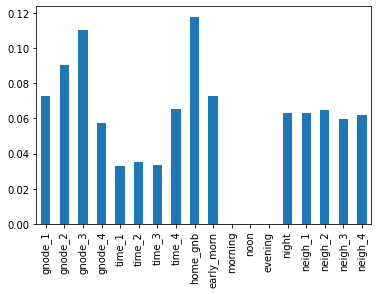

In [39]:
pd.Series(index=X_train.columns, data=importance).plot.bar()

In [40]:
import numpy as np

def compute_accuracy(y, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=['target_gnb', 'target_trans_slot'])
    gnb_pred_acc = (sum(y.target_gnb.values == y_pred.target_gnb.values) / len(y)) * 100
    timeslot_pred_acc = (sum(y.target_trans_slot.values == y_pred.target_trans_slot.values) / len(y)) * 100
    pred_accuracy = (sum((y.target_gnb.values == y_pred.target_gnb.values) &
                            (y.target_trans_slot.values == y_pred.target_trans_slot.values)) / len(y)) * 100
    return {
        "predictionAccuracy": pred_accuracy,
        "predictionTimeSlotAccuracy": timeslot_pred_acc,
        "predictionGnodeBAccuracy": gnb_pred_acc
    }

def topk_accuracy(actual_labels, pred_gnb, pred_time, k=3):
    actual_labels_size = len(actual_labels['target_gnb'])
    predictions_size = len(pred_gnb)
    if actual_labels_size != predictions_size:
        raise ValueError("actual and predicted should be of same size")
    results = np.zeros(actual_labels_size)
    for i in range(actual_labels_size):
        if ((actual_labels['target_gnb'][i] in set(pred_gnb[i][:k])) & (actual_labels['target_trans_slot'][i] in set(pred_time[i][:k]))):
            results[i] = 1
    return results.sum()/actual_labels_size

In [41]:
y_pred = model.predict(X_train)

In [42]:
accuracy = compute_accuracy(y_train, y_pred)
accuracy

{'predictionAccuracy': 69.45962108238875,
 'predictionTimeSlotAccuracy': 82.74076490255239,
 'predictionGnodeBAccuracy': 81.11391992171573}

In [43]:
probs = model.predict_proba(X_train)

In [44]:
gnb_preds = model.classes_[0][np.argsort(-probs[0])]
ts_preds = model.classes_[1][np.argsort(-probs[1])]

In [45]:
print(topk_accuracy(y_train.reset_index(), gnb_preds, ts_preds, k=1))
print(topk_accuracy(y_train.reset_index(), gnb_preds, ts_preds, k=3))
print(topk_accuracy(y_train.reset_index(), gnb_preds, ts_preds, k=5))

0.6945962108238876
0.9867623474408111
0.9997145885998532


The following class implements the very same data processing procedure used above. It's been compacted for convenience

In [46]:
class PreprocessData:
    def __init__(self, training_df,gnb_neigh):
        self.training_df = training_df
        self.gnb_neigh = gnb_neigh
    
    @staticmethod
    def window_sequence(seq, window_size=5):
        windows = []
        seq_len = len(seq)
        if seq_len < window_size:
            print(seq)
            padding_len = window_size - seq_len
        for i in range(len(seq) - window_size + 1):
            window = []
            for j in range(i, i + window_size):
                window.append(seq[j])
            windows.append(window)
        return windows

    def compute_home_gnb(self, grouped_df):
        ue_home_df = grouped_df.groupby(['imsi', 'currentEnb'])['stay_time'].sum().reset_index()
        home_gnb = ue_home_df.loc[ue_home_df.groupby(['imsi'])['stay_time'].idxmax()][['imsi', 'currentEnb']]
        home_gnb.columns = ['imsi', 'home_gnb']
        return home_gnb

    def compute_ue_context_df(self,grouped_df):
        grouped_df['time_of_day'] = pd.cut(grouped_df['timeSlot'], 
                                           bins=5,
                                           labels=['early_morn', 'morning', 'noon', 'evening', 'night'])
        ue_df = grouped_df.groupby(['imsi', 'time_of_day'])['currentEnb'].count().reset_index()
        ue_ctxt_df = pd.pivot_table(ue_df, index='imsi', columns='time_of_day', values='currentEnb', fill_value=0)
        return ue_ctxt_df

    def compute_transition_df(self, grouped_df):
        seq_df = grouped_df.groupby(['imsi'])['currentEnb', 'timeSlot','transition_slot'].agg(
            lambda x: list(x)).reset_index()
        seq_df['enode_seq'] = seq_df['currentEnb'].apply(self.window_sequence).values
        seq_df['time_seq'] = seq_df['timeSlot'].apply(self.window_sequence).values
        seq_df['trans_seq'] = seq_df['transition_slot'].apply(self.window_sequence).values
        enode_seq_list = [sequence for sequences in seq_df['enode_seq'] for sequence in sequences]
        time_seq_list = [sequence for sequences in seq_df['time_seq'] for sequence in sequences]
        trans_seq_list = [sequence for sequences in seq_df['trans_seq'] for sequence in sequences]
        seq_df['seq_len'] = seq_df['enode_seq'].apply(lambda x: len(x))
        imsi_list = list()
        for a, b in zip(seq_df['imsi'], seq_df['seq_len']):
            imsi_list.extend([a] * b)
        enode_df = pd.DataFrame(enode_seq_list, columns=['enode_1', 'enode_2', 'enode_3', 'enode_4', 'target_gnb'])
        time_df = pd.DataFrame(time_seq_list, columns=['time_1', 'time_2', 'time_3', 'time_4', 'target_time'])
        trans_df = pd.DataFrame(trans_seq_list, columns=['trans_1', 'trans_2', 'trans_3', 'trans_4', 'target_trans_slot'])
        df = pd.concat([enode_df, time_df], axis=1)
        #df = pd.concat([enode_df, time_df], axis=1)
        df['target_trans_slot'] = trans_df['target_trans_slot']
        df['imsi'] = imsi_list
        return df

    def preprocess_data(self):
        grouped_df = self.training_df.set_index(['imsi', 'timestamp']).sort_index().reset_index()
        grouped_df['next_timstamp'] = grouped_df.groupby(['imsi'])['timestamp'].shift(-1)
        grouped_df['prev_timstamp'] = grouped_df.groupby(['imsi'])['timestamp'].shift(1)
        grouped_df['stay_time'] = grouped_df['next_timstamp'] - grouped_df['timestamp']
        grouped_df['transit_time'] = grouped_df['timestamp'] - grouped_df['prev_timstamp']
        grouped_df['transition_slot'] = pd.cut(grouped_df['transit_time'], [0, 1, 5, 15, 30, 60, 3000],
                                               labels=[1, 5, 15, 30, 60, 100])

        home_gnb = self.compute_home_gnb(grouped_df)
        ue_ctxt_df = self.compute_ue_context_df(grouped_df)

        df = self.compute_transition_df(grouped_df)

        df = df.merge(home_gnb, on='imsi').merge(ue_ctxt_df, on='imsi')
        df = df.merge(self.gnb_neigh, left_on='enode_4', right_on='gnodeB', how='left')
        del df['gnodeB']
        df.dropna(inplace=True)
        y_train = df[['target_gnb', 'target_trans_slot']]

        to_drop_cols = ['target_gnb',
                        'target_trans_slot',
                        'target_time',
                        'imsi'
                       ]
        print(df.shape)
        df.drop(columns=to_drop_cols, inplace=True, axis=1)
        
        return df, y_train

In [47]:
day_2 = df.loc[(df['timestamp']>=1440) & (df['timestamp']<2880)]

preprocess_df = PreprocessData(day_2,gnb_neigh)
X_test, y_test = preprocess_df.preprocess_data()
y_pred = model.predict(X_test)

(65150, 22)


In [48]:
probs = model.predict_proba(X_test)
gnb_preds = model.classes_[0][np.argsort(-probs[0])]
ts_preds = model.classes_[1][np.argsort(-probs[1])]

In [49]:
print(topk_accuracy(y_test.reset_index(), gnb_preds, ts_preds, k=1))
print(topk_accuracy(y_test.reset_index(), gnb_preds, ts_preds, k=3))
print(topk_accuracy(y_test.reset_index(), gnb_preds, ts_preds, k=5))

0.6652954719877207
0.9810437452033768
0.9993706830391405


In [50]:
accuracy = compute_accuracy(y_test, y_pred)
accuracy

{'predictionAccuracy': 66.52954719877206,
 'predictionTimeSlotAccuracy': 81.45817344589409,
 'predictionGnodeBAccuracy': 78.92095165003838}

## Model sharing
### Pickle file

In [51]:
import joblib

joblib.dump(model, 'mobility_model.pkl')

['mobility_model.pkl']

### ONNX

Open Neural Network Exchange (ONNX)  is an open standard format for AI models, both deep learning and traditional ML. It defines an extensible computation graph model, as well as definitions of built-in operators and standard data types.

It is possible for most of the popular ML frameworks to export trained models as ONNX models. For scikit-learn: sklearn-onnx

In [52]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import Int64TensorType

In [53]:
X_train_onnx = X_train.to_numpy()
X_test_onnx = X_test.to_numpy()
y_train_onnx = y_train.to_numpy()
y_test_onnx = y_test.to_numpy()

In [54]:
initial_type = [('input', Int64TensorType([None, 18]))]
onx = convert_sklearn(model, initial_types=initial_type, options={type(model): {'zipmap': False}})

In [55]:
with open("mobility_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [56]:
import onnxruntime as rt

In [57]:
sess = rt.InferenceSession("mobility_model.onnx")

In [58]:
input_name = sess.get_inputs()[0].name

In [59]:
label_name = sess.get_outputs()[0].name

In [60]:
sess.run([label_name], {input_name: X_test_onnx[:1]})

[array([[13, 15]], dtype=int64)]

In [61]:
model.predict(X_test_onnx[:1])

array([[13, 15]])